# VADER

In [1]:
import nltk, time
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report, accuracy_score
from functools import reduce
import re
import numpy as np

In [2]:
def clean_review_info(text):
    text = re.sub(r'[0-9]+', '', text)
    repls = ('.', ' '), ('did n\'t', 'didn\'t'), ('wo n\'t', 'won\'t'), ('do n\'t', 'don\'t'), ('n\'t', ''), ('*', ''), (',', ' '), ('\'', ' '), ('-', ' ')
    return reduce(lambda a, kv: a.replace(*kv), repls, text)

In [3]:
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/simon/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# Load the reviews.csv file into a Pandas dataframe
reviews_df = pd.read_csv('tripadvisor_hotel_reviews.csv')
tripadvisor_df = pd.read_csv('tripadvisor_hotel_reviews.csv')
fine_food_df = pd.read_csv('amazon_fine_food_reviews.csv')
unlocked_df = pd.read_csv('Amazon_Unlocked_Mobile.csv')
google_df = pd.read_csv('google_play_store_reviews.csv')
clothing_df = pd.read_csv('Womens Clothing E-Commerce Reviews.csv')
unlocked_df = unlocked_df.dropna(subset=["Reviews"])
clothing_df = clothing_df.dropna(subset=["Review Text"])


In [ ]:
#tripadvisor_df.info()
#fine_food_df.info()
#unlocked_df.info()
#google_df.info()
#clothing_df.info()
"""
tripadvisor: Review, Rating
fine food: Text, Score
unlocked: Reviews, Rating
google: content, score
clothing: Review Text, Rating
"""

In [5]:
def map_rating_to_sentiment(row):
    if 'Rating' in row.keys():
        key = 'Rating'
    elif 'Score' in row.keys():
        key = 'Score'
    elif 'score' in row.keys():
        key = 'score'
    
    #rating = row['Rating']
    rating = row[key]
    if rating in [1,2]:
        return "Negative"
    elif rating in [3]:
        return "Neutral"
    elif rating in [4,5]:
        return "Positive"
    return "Unknown"

def map_rating_to_sentiment_score(row):
    #rating = row['Rating']
    if 'Rating' in row.keys():
        key = 'Rating'
    elif 'Score' in row.keys():
        key = 'Score'
    elif 'score' in row.keys():
        key = 'score'
    
    #rating = row['Rating']
    rating = row[key]
    if rating in [1,2]:
        return 1
    elif rating in [3]:
        return 2
    elif rating in [4,5]:
        return 3
    return -1

def get_compound_score(row):
    if 'Review' in row.keys():
        key = 'Review'
    elif 'Text' in row.keys():
        key = 'Text'
    elif 'content' in row.keys():
        key = 'content'
    elif 'Review Text' in row.keys():
        key = 'Review Text'
    elif 'Reviews' in row.keys():
        key = 'Reviews'
    sentiment_scores = sia.polarity_scores(row[key])
    return sentiment_scores['compound']

def get_prediction(review):
    sentiment_scores = sia.polarity_scores(review)
    if sentiment_scores['compound'] >= 0.05:
        return 'Positive'
    elif sentiment_scores['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'
    return 'Undefined'

Tripadvisor Hotel Reviews
Performance:
- Accuracy: 0.81
- Vader Prediction Time: 3.19s
- Classification Report:

              precision    recall  f1-score   support

    Negative       0.80      0.37      0.50       280
     Neutral       0.17      0.00      0.01       204
    Positive       0.81      0.99      0.89      1566

    accuracy                           0.81      2050
   macro avg       0.59      0.45      0.47      2050
weighted avg       0.75      0.81      0.75      2050



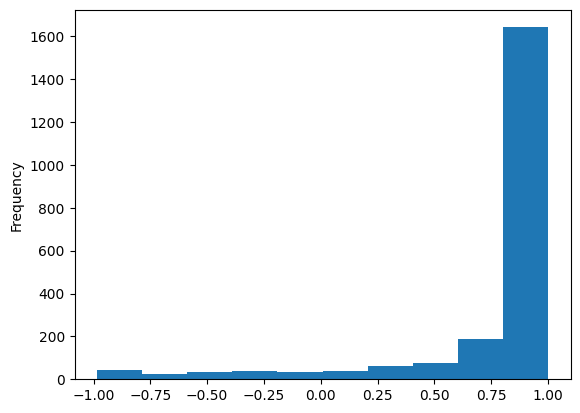

In [6]:
#Tripadvisor Hotel Reviews
tripadvisor_df['Sentiment'] = tripadvisor_df.apply(map_rating_to_sentiment, axis=1)
tripadvisor_df['Sentiment Score'] = tripadvisor_df.apply(map_rating_to_sentiment_score, axis=1)
no_of_reviews = len(tripadvisor_df)
sections = [int(0.8 * no_of_reviews), int(0.9 * no_of_reviews)]

reviews_train, reviews_test, reviews_val = np.split(
    ary = tripadvisor_df["Review"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)
y_sentiment_train, y_sentiment_test, y_sentiment_val = np.split(
    ary = tripadvisor_df["Sentiment"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)

tripadvisor_df['Compound Score'] = tripadvisor_df.apply(get_compound_score, axis=1)
pred_start = time.perf_counter()
val_predictions = reviews_val.apply(get_prediction)
pred_end = time.perf_counter()

# Calculate accuracy
accuracy = accuracy_score(y_sentiment_val, val_predictions)
tripadvisor_df[tripadvisor_df['Rating'] == 3]['Compound Score'].plot.hist()

print('Tripadvisor Hotel Reviews')
print(f'Performance:')
print(f'- Accuracy: {accuracy:.2f}')
print(f'- Vader Prediction Time: {pred_end - pred_start:.2f}s')
print(f'- Classification Report:\n')
print(classification_report(y_sentiment_val, val_predictions))

Amazon Fine Food Reviews
Performance:
- Accuracy: 0.81
- Vader Prediction Time: 47.62s
- Classification Report:

              precision    recall  f1-score   support

    Negative       0.54      0.40      0.46      7681
     Neutral       0.14      0.04      0.06      4103
    Positive       0.85      0.94      0.90     45062

    accuracy                           0.81     56846
   macro avg       0.51      0.46      0.47     56846
weighted avg       0.76      0.81      0.78     56846



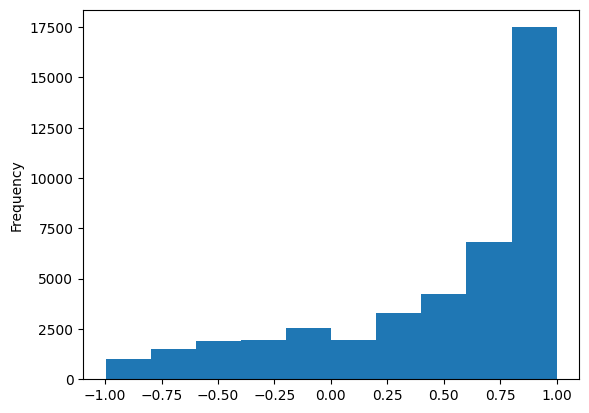

In [7]:
#Amazon Fine Food Reviews
fine_food_df['Sentiment'] = fine_food_df.apply(map_rating_to_sentiment, axis=1)
fine_food_df['Sentiment Score'] = fine_food_df.apply(map_rating_to_sentiment_score, axis=1)
no_of_reviews = len(fine_food_df)
sections = [int(0.8 * no_of_reviews), int(0.9 * no_of_reviews)]

reviews_train, reviews_test, reviews_val = np.split(
    ary = fine_food_df["Text"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)
y_sentiment_train, y_sentiment_test, y_sentiment_val = np.split(
    ary = fine_food_df["Sentiment"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)

fine_food_df['Compound Score'] = fine_food_df.apply(get_compound_score, axis=1)
pred_start = time.perf_counter()
val_predictions = reviews_val.apply(get_prediction)
pred_end = time.perf_counter()

# Calculate accuracy
accuracy = accuracy_score(y_sentiment_val, val_predictions)
fine_food_df[fine_food_df['Score'] == 3]['Compound Score'].plot.hist()

print('Amazon Fine Food Reviews')
print(f'Performance:')
print(f'- Accuracy: {accuracy:.2f}')
print(f'- Vader Prediction Time: {pred_end - pred_start:.2f}s')
print(f'- Classification Report:\n')
print(classification_report(y_sentiment_val, val_predictions))


In [8]:
#Amazon Unlocked Mobile
unlocked_df['Sentiment'] = unlocked_df.apply(map_rating_to_sentiment, axis=1)
unlocked_df['Sentiment Score'] = unlocked_df.apply(map_rating_to_sentiment_score, axis=1)
no_of_reviews = len(unlocked_df)
sections = [int(0.8 * no_of_reviews), int(0.9 * no_of_reviews)]

reviews_train, reviews_test, reviews_val = np.split(
    ary = unlocked_df["Reviews"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)
y_sentiment_train, y_sentiment_test, y_sentiment_val = np.split(
    ary = unlocked_df["Sentiment"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)

#unlocked_df['Compound Score'] = unlocked_df.apply(get_compound_score, axis=1)
pred_start = time.perf_counter()
val_predictions = reviews_val.apply(get_prediction)
pred_end = time.perf_counter()

# Calculate accuracy
accuracy = accuracy_score(y_sentiment_val, val_predictions)
#unlocked_df[unlocked_df['Rating'] == 3]['Compound Score'].plot.hist()

print('Amazon Unlocked Mobile')
print(f'Performance:')
print(f'- Accuracy: {accuracy:.2f}')
print(f'- Vader Prediction Time: {pred_end - pred_start:.2f}s')
print(f'- Classification Report:\n')
print(classification_report(y_sentiment_val, val_predictions))

Amazon Unlocked Mobile
Performance:
- Accuracy: 0.71
- Vader Prediction Time: 22.80s
- Classification Report:

              precision    recall  f1-score   support

    Negative       0.69      0.55      0.61     10246
     Neutral       0.10      0.14      0.11      3773
    Positive       0.82      0.84      0.83     27359

    accuracy                           0.71     41378
   macro avg       0.54      0.51      0.52     41378
weighted avg       0.72      0.71      0.71     41378



Google Play Store Reviews
Performance:
- Accuracy: 0.63
- Vader Prediction Time: 0.32s
- Classification Report:

              precision    recall  f1-score   support

    Negative       0.71      0.43      0.53       400
     Neutral       0.15      0.20      0.17       150
    Positive       0.72      0.83      0.77       700

    accuracy                           0.63      1250
   macro avg       0.53      0.49      0.49      1250
weighted avg       0.65      0.63      0.62      1250



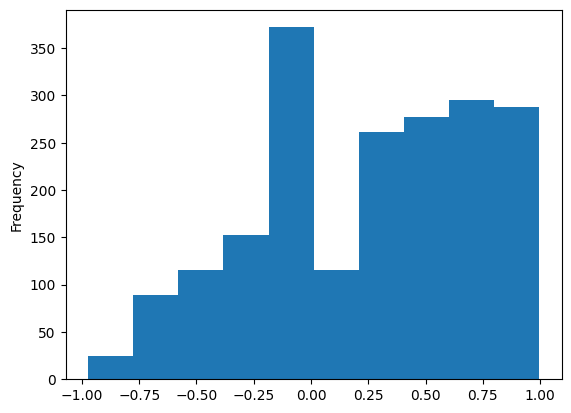

In [9]:
#Google Play Store Reviews
google_df['Sentiment'] = google_df.apply(map_rating_to_sentiment, axis=1)
google_df['Sentiment Score'] = google_df.apply(map_rating_to_sentiment_score, axis=1)
no_of_reviews = len(google_df)
sections = [int(0.8 * no_of_reviews), int(0.9 * no_of_reviews)]

reviews_train, reviews_test, reviews_val = np.split(
    ary = google_df["content"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)
y_sentiment_train, y_sentiment_test, y_sentiment_val = np.split(
    ary = google_df["Sentiment"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)

google_df['Compound Score'] = google_df.apply(get_compound_score, axis=1)
pred_start = time.perf_counter()
val_predictions = reviews_val.apply(get_prediction)
pred_end = time.perf_counter()

# Calculate accuracy
accuracy = accuracy_score(y_sentiment_val, val_predictions)
google_df[google_df['score'] == 3]['Compound Score'].plot.hist()

print('Google Play Store Reviews')
print(f'Performance:')
print(f'- Accuracy: {accuracy:.2f}')
print(f'- Vader Prediction Time: {pred_end - pred_start:.2f}s')
print(f'- Classification Report:\n')
print(classification_report(y_sentiment_val, val_predictions))

Womens Clothing E-Commerce Reviews
Performance:
- Accuracy: 0.79
- Vader Prediction Time: 1.46s
- Classification Report:

              precision    recall  f1-score   support

    Negative       0.44      0.27      0.34       228
     Neutral       0.32      0.03      0.06       265
    Positive       0.82      0.97      0.89      1772

    accuracy                           0.79      2265
   macro avg       0.53      0.42      0.43      2265
weighted avg       0.72      0.79      0.74      2265



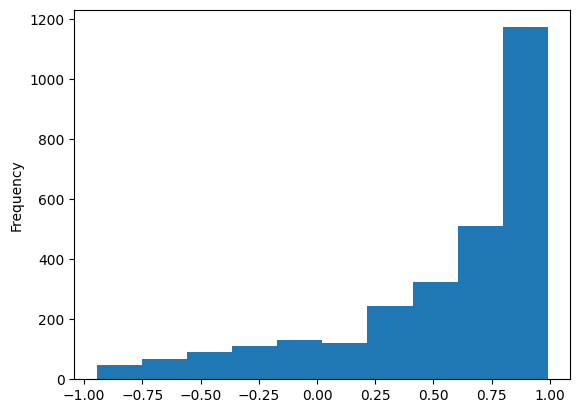

In [10]:
#Womens Clothing E-Commerce Reviews
clothing_df['Sentiment'] = clothing_df.apply(map_rating_to_sentiment, axis=1)
clothing_df['Sentiment Score'] = clothing_df.apply(map_rating_to_sentiment_score, axis=1)
no_of_reviews = len(clothing_df)
sections = [int(0.8 * no_of_reviews), int(0.9 * no_of_reviews)]

reviews_train, reviews_test, reviews_val = np.split(
    ary = clothing_df["Review Text"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)
y_sentiment_train, y_sentiment_test, y_sentiment_val = np.split(
    ary = clothing_df["Sentiment"],             # Array to split (i.e. our DataFrame of reviews)
    indices_or_sections = sections          # Sections to split (i.e. split at 80% and 90% mark)
)

clothing_df['Compound Score'] = clothing_df.apply(get_compound_score, axis=1)
pred_start = time.perf_counter()
val_predictions = reviews_val.apply(get_prediction)
pred_end = time.perf_counter()

# Calculate accuracy
accuracy = accuracy_score(y_sentiment_val, val_predictions)
clothing_df[clothing_df['Rating'] == 3]['Compound Score'].plot.hist()

print('Womens Clothing E-Commerce Reviews')
print(f'Performance:')
print(f'- Accuracy: {accuracy:.2f}')
print(f'- Vader Prediction Time: {pred_end - pred_start:.2f}s')
print(f'- Classification Report:\n')
print(classification_report(y_sentiment_val, val_predictions))